# Imports and config

In [84]:
import os
import pickle
import warnings
import random
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

import config as cfg
import data_processing as dp


warnings.filterwarnings('ignore')
plt.style.use('seaborn-dark-palette')

# Data preparation

### Load data

In [2]:
sales = pd.read_csv(cfg.FILENAMES['TRAIN_SALES'])

items = pd.read_csv(cfg.FILENAMES["ITEMS"])

categories = pd.read_csv(cfg.FILENAMES["ITEM_CATEGORIES"])

shops = pd.read_csv(cfg.FILENAMES["SHOPS"])

### Categories features

In [4]:
print(len(categories))
categories.head(2)

84


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [5]:
category_names = list(categories["item_category_name"])
categories["item_category_name_en"] = dp.translate_string_list(category_names)

categories["item_category_name_en_cur"] = dp.process_categories(categories["item_category_name_en"])

main_sub_category_colnames = ["main_category_name", "sub_category_name"]
categories[main_sub_category_colnames] = categories["item_category_name_en_cur"].str.split(" - ", expand=True)
categories.head(2)

,item_category_name,item_category_id,item_category_name_en,item_category_name_en_cur,main_category_name,sub_category_name
0,PC - Гарнитуры/Наушники,0,PC - Headsets / Headphones,Accessories - PC,Accessories,PC
1,Аксессуары - PS2,1,Accessories - PS2,Accessories - PS2,Accessories,PS2


In [6]:
categories = categories[["item_category_id","main_category_name", "sub_category_name"]]
categories.head(1)

,item_category_id,main_category_name,sub_category_name
0,0,Accessories,PC


## Shop features

In [7]:
print(len(shops))
shops.head(2)

60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [8]:
shops["city_rus"] = shops["shop_name"].str.split(" ",expand=True)[0]
shop_names = [x.replace("!","") for x in shops["city_rus"]]
shops["city_name"] = dp.translate_string_list(shop_names)

shops["city_name"] = dp.process_shops(shops["city_name"])
shops.head(2)

,shop_name,shop_id,city_rus,city_name
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,Yakutsk
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,Yakutsk


In [9]:
shops = shops[["shop_id","city_name"]]
shops.head(2)

,shop_id,city_name
0,0,Yakutsk
1,1,Yakutsk


## Items features

No item feature has been computed yet. We'll just use this table to link items with their category.

In [10]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


## Remove train negative values and outliers

In [11]:
print(len(sales))
sales.head(3)

2935849


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


##### Remove negative values

In [12]:
sales_pos = sales.loc[sales["item_cnt_day"]>0]
print(f"From {len(sales)} to {len(sales_pos)}")

From 2935849 to 2928493


##### Remove outliers

In [13]:
sales_pos.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894664e+02,1.248337e+00
std,9.422952e+00,1.622543e+01,6.324396e+03,1.727498e+03,2.619586e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [14]:
print(len(sales_pos[sales_pos["item_cnt_day"]>50]))
sales_pos.loc[sales_pos["item_cnt_day"]>50]

523


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
70814,02.01.2013,0,31,13598,10.000000,64.0
122430,05.02.2013,1,42,2749,1070.698113,53.0
239024,12.03.2013,2,31,6738,699.000000,88.0
244068,08.03.2013,2,31,3320,999.494231,52.0
269148,12.03.2013,2,42,6738,698.994643,56.0
...,...,...,...,...,...,...
2909818,28.10.2015,33,12,11373,0.908714,2169.0
2918659,02.10.2015,33,9,7018,299.000000,67.0
2918694,03.10.2015,33,9,4201,399.000000,62.0
2918705,02.10.2015,33,9,4201,399.000000,110.0


In [15]:
peak_sales_item_ids = set(sales_pos.loc[sales_pos["item_cnt_day"]>50,"item_id"])
print(random.sample(list(items.loc[items["item_id"].isin(peak_sales_item_ids),"item_name"].values), k=10))

['Средиземье: Тени Мордора [PC, Jewel, русские субтитры]', 'Remember me [PC, Jewel, русские субтитры]', 'Билет "ИгроМир 2015" - 3 октября 2015 УПР [Цифровая версия]', 'Of Orcs and Men [PC, Jewel, русские субтитры]', 'Средиземье: Тени Мордора. Season Pass [PC, Цифровая версия]', 'Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)', "Assassin's Creed IV. Черный флаг. Special Edition [PC, русская версия]", 'Доставка (Почта)', "Assassin's Creed: Изгой. Коллекционное издание [PC, русская версия]", "Mortal Kombat X. Kollector's Edition [PS4, русские субтитры]"]


Analysis: those peak numbers come from either an error, or the selling of a product on its release date. We should then clip all training daily values to [0,50].

In [16]:
sales_pos.loc[sales["item_cnt_day"]>50, "item_cnt_day"] = 50

In [17]:
sales_pos.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894664e+02,1.238134e+00
std,9.422952e+00,1.622543e+01,6.324396e+03,1.727498e+03,1.469850e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,5.000000e+01


In [18]:
sales_pos.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


## Aggregate sales per month

In [19]:
sales_monthly = (sales_pos.groupby(["date_block_num","shop_id","item_id"])
                            .agg({"date":"first", #we will just extract month and year from it
                                 "item_price": ["mean", "std"],
                                 "item_cnt_day": ["sum","count"]})
                            .reset_index())
sales_monthly.columns = ["date_block_num", "shop_id", "item_id",
                     "random_date", "mean_item_price", "std_item_price",
                      "item_cnt_month", "days_with_sell"]
sales_monthly["std_item_price"] = sales_monthly["std_item_price"].fillna(0)
print(len(sales_monthly))
sales_monthly.head(2)

1608226


,date_block_num,shop_id,item_id,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell
0,0,0,32,03.01.2013,221.0,0.0,6.0,4
1,0,0,33,03.01.2013,347.0,0.0,3.0,3


In [20]:
sales_monthly.describe()

,date_block_num,shop_id,item_id,mean_item_price,std_item_price,item_cnt_month,days_with_sell
count,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06,1.608226e+06
mean,1.466502e+01,3.280798e+01,1.068148e+04,7.901510e+02,8.339656e+00,2.254576e+00,1.820946e+00
std,9.542384e+00,1.653645e+01,6.238856e+03,1.549310e+03,7.358666e+01,7.544538e+00,1.978750e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,0.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+00,2.100000e+01,5.046000e+03,1.990000e+02,0.000000e+00,1.000000e+00,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,3.990000e+02,0.000000e+00,1.000000e+00,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.606000e+04,8.949638e+02,0.000000e+00,2.000000e+00,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,1.694603e+04,1.150000e+03,3.100000e+01


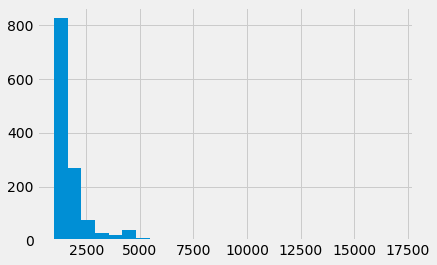

In [21]:
plt.hist(sales_monthly.loc[sales_monthly["std_item_price"]>1000,"std_item_price"], bins=25)
plt.show()

In [22]:
threshold = 100
print(len(sales_monthly.loc[sales_monthly["std_item_price"]<=threshold,]))
print(sales_monthly.loc[sales_monthly["std_item_price"]<=threshold,"item_cnt_month"].mean())
print()
print(len(sales_monthly.loc[sales_monthly["std_item_price"]>threshold,]))
print(sales_monthly.loc[sales_monthly["std_item_price"]>threshold,"item_cnt_month"].mean())

1573330
2.15833423375897

34896
6.593764328289775


In [23]:
threshold = 3500
print(len(sales_monthly.loc[sales_monthly["mean_item_price"]<=threshold,]))
print(sales_monthly.loc[sales_monthly["mean_item_price"]<=threshold,"item_cnt_month"].mean())
print()
print(len(sales_monthly.loc[sales_monthly["mean_item_price"]>threshold,]))
print(sales_monthly.loc[sales_monthly["mean_item_price"]>threshold,"item_cnt_month"].mean())

1578296
2.243511990146335

29930
2.8380220514533914


Analysis: The variation of std(item_price) seems to be an important regressor.

## Add missing combinations

In [24]:
len(sales[sales["item_cnt_day"]==0])

0

There isn't any observation with item_cnt_day = 0. That means that there is no observation whenever some item isn't sold in a shop. We must account for these values.

In [25]:
release_date_items={}

nb_items = len(set(sales_monthly["item_id"]))
for c, i_id in enumerate(set(sales_monthly["item_id"])):
    release_date_items[i_id] = min(sales_monthly.loc[sales_monthly["item_id"]==i_id, "date_block_num"])
    if c%5000==0:
        print(f"{c} / {nb_items} done")
list(release_date_items.items())[:10]

0 / 21804 done
5000 / 21804 done
10000 / 21804 done
15000 / 21804 done
20000 / 21804 done


[(0, 20),
 (1, 15),
 (2, 19),
 (3, 18),
 (4, 20),
 (5, 23),
 (6, 18),
 (7, 23),
 (8, 19),
 (9, 19)]

In [26]:
combinations = []

nb_shops = len(set(sales_monthly["shop_id"]))
for c, s_id in enumerate(set(sales_monthly["shop_id"])):
    for i_id in set(sales_monthly.loc[sales_monthly["shop_id"]==s_id,"item_id"]):
        release_date = release_date_items[i_id]
        for m in range(release_date, 34):
            combinations.append({"shop_id":s_id, "item_id":i_id, "date_block_num":m})
    if (c+1)%10==0:
        print(f"{c+1} / {nb_shops} done")

combinations[:10]

10 / 60 done
20 / 60 done
30 / 60 done
40 / 60 done
50 / 60 done
60 / 60 done


[{'shop_id': 0, 'item_id': 16385, 'date_block_num': 0},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 1},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 2},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 3},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 4},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 5},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 6},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 7},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 8},
 {'shop_id': 0, 'item_id': 16385, 'date_block_num': 9}]

In [27]:
empty_df = pd.DataFrame(combinations, columns = combinations[0].keys())
print(len(empty_df))
empty_df.head(2)

11158029


,shop_id,item_id,date_block_num
0,0,16385,0
1,0,16385,1


In [28]:
sales_monthly_complete = pd.merge(empty_df, sales_monthly, how="left", on=["shop_id","item_id","date_block_num"])
print(len(sales_monthly_complete))
print(sales_monthly_complete.isnull().sum())
sales_monthly_complete.head(2)

11158029
shop_id                  0
item_id                  0
date_block_num           0
random_date        9549803
mean_item_price    9549803
std_item_price     9549803
item_cnt_month     9549803
days_with_sell     9549803
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0


## Merge all tables
sales_monthly, shops, categories and items

In [29]:
sales_monthly_complete.head(1)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0


In [30]:
categories.head(1)

,item_category_id,main_category_name,sub_category_name
0,0,Accessories,PC


In [31]:
bigboi = pd.merge(sales_monthly_complete, items, how="left", on="item_id")
bigboi = pd.merge(bigboi, categories, how="left", on="item_category_id")
bigboi = pd.merge(bigboi, shops, how="left", on="shop_id")
print(f"From {len(sales_monthly_complete)} to {len(bigboi)} --> SHOULD NOT CHANGE")
bigboi.head(2)

From 11158029 to 11158029 --> SHOULD NOT CHANGE


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk


## Fill NA values

In [32]:
bigboi.isnull().sum()

shop_id                     0
item_id                     0
date_block_num              0
random_date           9549803
mean_item_price       9549803
std_item_price        9549803
item_cnt_month        9549803
days_with_sell        9549803
item_name                   0
item_category_id            0
main_category_name          0
sub_category_name           0
city_name                   0
dtype: int64

#### item_cnt_month & days_with_sell

item_cnt_month and days_with_sell should be filled with 0

In [33]:
bigboi[["item_cnt_month","days_with_sell"]] = bigboi[["item_cnt_month","days_with_sell"]].fillna(0)

#### mean_item_price and std_item_price

mean_item_price and std_item_price should be filled with a similar value but which one?
- average at a shop x item level
- average at a item x month level
?

##### shop x item level EDA

In [34]:
(bigboi.dropna()
             .groupby(["shop_id","item_id"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,shop_id,item_id,mean_item_price,std_item_price
count,277362.000000,277362.000000,277362.000000,277362.000000
mean,32.446914,11199.420335,92.547248,11.201097
std,16.718642,6187.040768,224.228914,58.549466
min,0.000000,1.000000,0.000000,0.000000
25%,19.000000,5797.000000,0.000000,0.000000
50%,31.000000,11240.000000,2.223805,0.000000
75%,47.000000,16468.750000,98.003904,0.000000
max,59.000000,22168.000000,7886.050611,3866.865000


##### item x month

In [35]:
(bigboi.dropna()
             .groupby(["item_id","date_block_num"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,item_id,date_block_num,mean_item_price,std_item_price
count,167947.000000,167947.000000,167947.000000,167947.000000
mean,11556.170857,14.474864,27.927520,5.362690
std,6130.550785,9.671751,84.919836,35.405984
min,27.000000,0.000000,0.000000,0.000000
25%,6343.000000,6.000000,0.000000,0.000000
50%,11758.000000,13.000000,0.000000,0.000000
75%,16743.500000,23.000000,30.156127,0.000000
max,22168.000000,33.000000,6830.053294,2653.613888


We observe that the distribution of mean_item_price and std_item_price is more regular on a item x month level. We'll fill NA values according to this granularity.

In [36]:
itemxmonth_mean = (bigboi.dropna()
             .groupby(["item_id","date_block_num"])
             .agg({"mean_item_price":"mean", "std_item_price":"mean"})
             .reset_index())
itemxmonth_mean.head(2)

,item_id,date_block_num,mean_item_price,std_item_price
0,0,20,58.0,0.0
1,1,15,4490.0,0.0


In [53]:
bigboi_filled = pd.merge(bigboi, itemxmonth_mean,
                                    how="left", on=["item_id","date_block_num"], suffixes=["","_fill"])

bigboi_filled["mean_item_price"] = bigboi_filled["mean_item_price"].fillna(bigboi_filled["mean_item_price_fill"])
bigboi_filled["std_item_price"] = bigboi_filled["std_item_price"].fillna(bigboi_filled["std_item_price_fill"])

bigboi_filled = bigboi_filled.drop(["mean_item_price_fill", "std_item_price_fill"], axis=1)

print(bigboi_filled.isnull().sum())
bigboi_filled.head(2)

shop_id                     0
item_id                     0
date_block_num              0
random_date           9549803
mean_item_price       4355967
std_item_price        4355967
item_cnt_month              0
days_with_sell              0
item_name                   0
item_category_id            0
main_category_name          0
sub_category_name           0
city_name                   0
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk


Now, second step, fill with something more general?
- shop x item ?
- category x month?
- item ?

##### shop x item level

In [54]:
(bigboi_filled.dropna()
             .groupby(["shop_id","item_id"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,shop_id,item_id,mean_item_price,std_item_price
count,277362.000000,277362.000000,277362.000000,277362.000000
mean,32.446914,11199.420335,92.547248,11.201097
std,16.718642,6187.040768,224.228914,58.549466
min,0.000000,1.000000,0.000000,0.000000
25%,19.000000,5797.000000,0.000000,0.000000
50%,31.000000,11240.000000,2.223805,0.000000
75%,47.000000,16468.750000,98.003904,0.000000
max,59.000000,22168.000000,7886.050611,3866.865000


##### category x month

In [55]:
(bigboi_filled.dropna()
             .groupby(["item_category_id","date_block_num"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,item_category_id,date_block_num,mean_item_price,std_item_price
count,2026.000000,2026.000000,2026.000000,2026.000000
mean,43.246792,16.875617,739.120426,59.021327
std,24.283090,9.710696,885.382164,200.282821
min,2.000000,0.000000,0.000000,0.000000
25%,22.000000,9.000000,169.593957,0.069467
50%,43.000000,17.000000,427.865816,11.271593
75%,65.000000,25.000000,972.109220,42.825464
max,83.000000,33.000000,11270.414843,6446.442930


##### item level

In [56]:
(bigboi_filled.dropna()
             .groupby(["item_id"])
             .agg({"mean_item_price":"std", "std_item_price":"std"})
             .dropna()
             .reset_index()
             .describe())

,item_id,mean_item_price,std_item_price
count,19283.000000,19283.000000,19283.000000
mean,11271.343671,95.377193,10.168821
std,6268.124735,203.426974,49.887337
min,1.000000,0.000000,0.000000
25%,5893.500000,16.037444,0.000000
50%,11340.000000,35.565185,0.000000
75%,16663.500000,96.760138,3.094107
max,22168.000000,5813.875386,2827.273413


We observe that the distribution of mean_item_price and std_item_price is more regular on a item x month level. We'll fill NA values according to this granularity.

In [57]:
item_mean = (bigboi.dropna()
             .groupby(["item_id"])
             .agg({"mean_item_price":"mean", "std_item_price":"mean"})
             .reset_index())
item_mean.head(2)

,item_id,mean_item_price,std_item_price
0,0,58.0,0.0
1,1,4490.0,0.0


In [58]:
bigboi_filled = pd.merge(bigboi_filled, item_mean,
                                    how="left", on=["item_id"], suffixes=["","_fill"])

bigboi_filled["mean_item_price"] = bigboi_filled["mean_item_price"].fillna(bigboi_filled["mean_item_price_fill"])
bigboi_filled["std_item_price"] = bigboi_filled["std_item_price"].fillna(bigboi_filled["std_item_price_fill"])

bigboi_filled = bigboi_filled.drop(["mean_item_price_fill", "std_item_price_fill"], axis=1)

print(bigboi_filled.isnull().sum())
bigboi_filled.head(2)

shop_id                     0
item_id                     0
date_block_num              0
random_date           9549803
mean_item_price             0
std_item_price              0
item_cnt_month              0
days_with_sell              0
item_name                   0
item_category_id            0
main_category_name          0
sub_category_name           0
city_name                   0
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk


#### random_date

In [59]:
random_dates = bigboi_filled.dropna().groupby("date_block_num").agg({"random_date":"first"}).reset_index()
bigboi_filled = pd.merge(bigboi_filled, random_dates, how="left", on="date_block_num", suffixes=["","_fill"])
bigboi_filled["random_date"] = bigboi_filled["random_date"].fillna(bigboi_filled["random_date_fill"])
bigboi_filled = bigboi_filled.drop("random_date_fill", axis=1)

print(bigboi_filled.isnull().sum())
bigboi_filled.head(2)

shop_id               0
item_id               0
date_block_num        0
random_date           0
mean_item_price       0
std_item_price        0
item_cnt_month        0
days_with_sell        0
item_name             0
item_category_id      0
main_category_name    0
sub_category_name     0
city_name             0
dtype: int64


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk


#### Intermediate export

In [61]:
bigboi_filled.to_pickle("cleaned_sets/shopxitemxmonth_filled.pkl")

In [142]:
bigboi_filled = pd.read_pickle("cleaned_sets/shopxitemxmonth_filled.pkl")

## Existing feature EDA

##### mean_item_price & std_item_price

In [64]:
threshold = 100
print(len(bigboi_filled.loc[bigboi_filled["std_item_price"]<=threshold,]))
print(bigboi_filled.loc[bigboi_filled["std_item_price"]<=threshold,"item_cnt_month"].mean())
print()
print(len(bigboi_filled.loc[bigboi_filled["std_item_price"]>threshold,]))
print(bigboi_filled.loc[bigboi_filled["std_item_price"]>threshold,"item_cnt_month"].mean())

11077974
0.3065336676182847

80055
2.8742239710199238


In [65]:
threshold = 3500
print(len(bigboi_filled.loc[bigboi_filled["mean_item_price"]<=threshold,]))
print(bigboi_filled.loc[bigboi_filled["mean_item_price"]<=threshold,"item_cnt_month"].mean())
print()
print(len(bigboi_filled.loc[bigboi_filled["mean_item_price"]>threshold,]))
print(bigboi_filled.loc[bigboi_filled["mean_item_price"]>threshold,"item_cnt_month"].mean())

10960364
0.32306646020150426

197665
0.4297270634659651


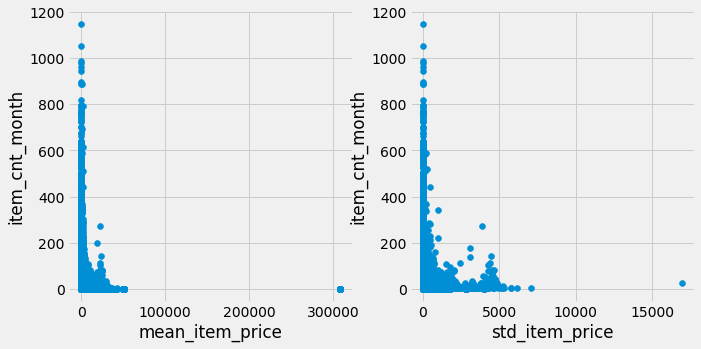

In [70]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax = plt.gca()
ax.scatter(bigboi_filled["mean_item_price"], bigboi_filled["item_cnt_month"])
ax.set_xlabel("mean_item_price")
ax.set_ylabel("item_cnt_month")

plt.subplot(1,2,2)
ax = plt.gca()
ax.scatter(bigboi_filled["std_item_price"], bigboi_filled["item_cnt_month"])
ax.set_xlabel("std_item_price")
ax.set_ylabel("item_cnt_month")

plt.show()

std_item_price looks interesting, threshold?

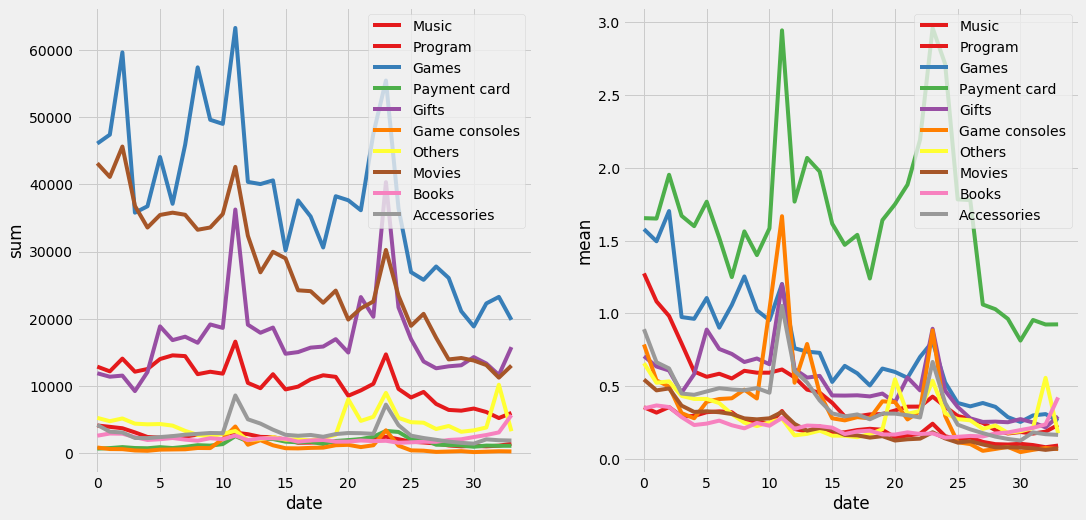

In [96]:
bb_cat = (bigboi_filled.groupby(["main_category_name","date_block_num"])
          .agg({"item_cnt_month": ["sum", "mean"]})
          .reset_index())

bb_cat.columns = ["main_category_name", "date_block_num", "item_cnt_month_sum", "item_cnt_month_mean"]


colormap = plt.cm.Set1
cyc = cycler('color', [colormap(i) for i in np.linspace(0, 0.9, len(set(bb_cat["main_category_name"])))])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
ax = plt.gca()
ax.set_prop_cycle(cyc)


for i, cat in enumerate(set(bb_cat["main_category_name"])):
    bb_cat_tmp = bb_cat.loc[bb_cat["main_category_name"]==cat,]
    ax.plot(bb_cat_tmp["date_block_num"], bb_cat_tmp["item_cnt_month_sum"], label=cat)

ax.set_xlabel("date")
ax.set_ylabel("sum")
plt.legend()

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_prop_cycle(cyc)

for i, cat in enumerate(set(bb_cat["main_category_name"])):
    bb_cat_tmp = bb_cat.loc[bb_cat["main_category_name"]==cat,]
    ax.plot(bb_cat_tmp["date_block_num"], bb_cat_tmp["item_cnt_month_mean"], label=cat)

ax.set_xlabel("date")
ax.set_ylabel("mean")
plt.legend()
    
plt.show()

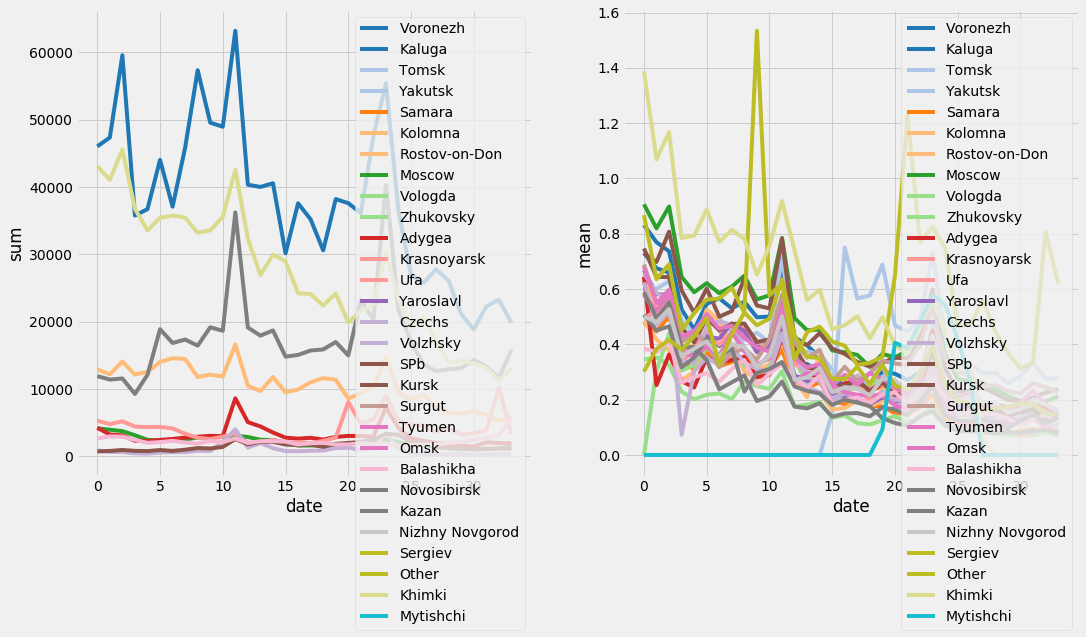

In [101]:
bb_city = (bigboi_filled.groupby(["city_name","date_block_num"])
          .agg({"item_cnt_month": ["sum", "mean"]})
          .reset_index())

bb_city.columns = ["city_name", "date_block_num", "item_cnt_month_sum", "item_cnt_month_mean"]


colormap = plt.cm.tab20
cyc = cycler('color', [colormap(i) for i in np.linspace(0, 0.9, len(set(bb_city["city_name"])))])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
ax = plt.gca()
ax.set_prop_cycle(cyc)


for i, city in enumerate(set(bb_city["city_name"])):
    bb_city_tmp = bb_cat.loc[bb_city["city_name"]==city,]
    ax.plot(bb_city_tmp["date_block_num"], bb_city_tmp["item_cnt_month_sum"], label=city)

ax.set_xlabel("date")
ax.set_ylabel("sum")
plt.legend()

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_prop_cycle(cyc)

for i, city in enumerate(set(bb_city["city_name"])):
    bb_city_tmp = bb_city.loc[bb_city["city_name"]==city,]
    ax.plot(bb_city_tmp["date_block_num"], bb_city_tmp["item_cnt_month_mean"], label=city)

ax.set_xlabel("date")
ax.set_ylabel("mean")
plt.legend()
    
plt.show()

May be interesting but too much values to use as raw, compute shop based features such as mean rather than raw city name dummies.

## Remove outliers

In [143]:
bigboi_filled.head(2)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk


In [144]:
print(len(bigboi_filled))
bigboi_filled.describe()

11158029


,shop_id,item_id,date_block_num,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_category_id
count,1.115803e+07,1.115803e+07,1.115803e+07,1.115803e+07,1.115803e+07,1.115803e+07,1.115803e+07,1.115803e+07
mean,3.128069e+01,1.143937e+04,1.858636e+01,6.750846e+02,3.292438e+00,3.249560e-01,2.624561e-01,4.259990e+01
std,1.701048e+01,6.128150e+03,9.455345e+00,1.462181e+03,3.288632e+01,2.971704e+00,9.865982e-01,1.478843e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.800000e+01,6.285000e+03,1.100000e+01,1.881949e+02,0.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01
50%,3.000000e+01,1.154900e+04,1.900000e+01,2.990000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01
75%,4.600000e+01,1.668200e+04,2.700000e+01,6.591667e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.300000e+01,3.079800e+05,1.694603e+04,1.150000e+03,3.100000e+01,8.300000e+01


In [145]:
print(len(bigboi_filled[bigboi_filled["item_cnt_month"]>1000]))
bigboi_filled.loc[bigboi_filled["item_cnt_month"]>1000]

2


,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
6125294,31,20949,11,21.12.2013,4.99871,0.007184,1150.0,31.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,Gifts,"Bags, Albums, Mats d / mouse",Moscow
6125306,31,20949,23,31.12.2014,5.00000,0.000000,1052.0,31.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,Gifts,"Bags, Albums, Mats d / mouse",Moscow


## Create label

In [146]:
bigboi_filled.head(2)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk


In [147]:
bigboi_filled["item_cnt_next_month"] = (bigboi_filled.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["item_cnt_month"].shift(-1))

In [148]:
#check
bigboi_filled.loc[(bigboi_filled["item_id"]==20949) & 
                  (bigboi_filled["shop_id"]==31),["item_cnt_month","item_cnt_next_month"]].head(3)

,item_cnt_month,item_cnt_next_month
6125286,13.0,384.0
6125287,384.0,763.0
6125288,763.0,799.0


# Feature Engineering

In [149]:
df_fe = bigboi_filled.copy()
df_fe.head(1)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name,item_cnt_next_month
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,2.0


Ideas of features:
- Year, month DONE
- Nb of days in month DONE
- Lag of mean_price, std_price (-1,-2) DONE
- Lag of item_cnt_month (-1,-2, -12) DONE
- Category x month based mean DONE
- Shop x month based mean DONE
- Lag of these variables DONE
- Is lowest price within the city? DONE
--------- Split between train, valid and test  
--------- Perform feature select using SelectFromModel

Ideas for later:
- Rolling means
- 

##### Year, month, # days in month

In [150]:
def month_year(x):
    return int(x[3:5]),int(x[7:])

In [151]:
df_fe["month"],df_fe["year"] = zip(*df_fe["random_date"].map(month_year))
df_fe.head()

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name,item_cnt_next_month,month,year
0,0,16385,0,20.01.2013,200.000000,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,2.0,1,13
1,0,16385,1,25.02.2013,200.000000,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,0.0,2,13
2,0,16385,2,01.03.2013,348.937500,0.0,0.0,0.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,0.0,3,13
3,0,16385,3,21.04.2013,349.000000,0.0,0.0,0.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,0.0,4,13
4,0,16385,4,29.05.2013,315.333333,0.0,0.0,0.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,0.0,5,13


In [152]:
month_to_days={1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8: 31, 9:30, 10:31, 11:30, 12:31}
df_fe["nb_days"] = df_fe["month"].apply(month_to_days.get)
df_fe.head(2)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,main_category_name,sub_category_name,city_name,item_cnt_next_month,month,year,nb_days
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,2.0,1,13,31
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,Games,PC,Yakutsk,0.0,2,13,28


##### Lag of mean_price, std_price (-1,-2)

In [153]:
df_fe["mean_item_price_lag1"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["mean_item_price"].shift(1))
df_fe["mean_item_price_lag2"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["mean_item_price"].shift(2))

In [154]:
#check
df_fe.loc[(bigboi_filled["item_id"]==20949) & (df_fe["shop_id"]==31),
                  ["mean_item_price","mean_item_price_lag1", "mean_item_price_lag2"]].head()

,mean_item_price,mean_item_price_lag1,mean_item_price_lag2
6125286,5.000000,NaN,NaN
6125287,5.000000,5.000000,NaN
6125288,4.998039,5.000000,5.000000
6125289,4.999390,4.998039,5.000000
6125290,5.000000,4.999390,4.998039


In [155]:
df_fe["std_item_price_lag1"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["std_item_price"].shift(1))
df_fe["std_item_price_lag2"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["std_item_price"].shift(2))

#check
df_fe.loc[(df_fe["item_id"]==20949) & (df_fe["shop_id"]==31),
                  ["std_item_price","std_item_price_lag1", "std_item_price_lag2"]].head()

,std_item_price,std_item_price_lag1,std_item_price_lag2
6125286,0.000000,NaN,NaN
6125287,0.000000,0.000000,NaN
6125288,0.010740,0.000000,0.00000
6125289,0.002903,0.010740,0.00000
6125290,0.000000,0.002903,0.01074


##### Lag of item_cnt_month (-1,-2, -12)

In [156]:
df_fe["item_cnt_month_lag1"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["item_cnt_month"].shift(1))
df_fe["item_cnt_month_lag2"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["item_cnt_month"].shift(2))
df_fe["item_cnt_month_lag12"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])["item_cnt_month"].shift(12))

#check
df_fe.loc[(df_fe["item_id"]==20949) & (df_fe["shop_id"]==31),
                  ["item_cnt_month","item_cnt_month_lag1", "item_cnt_month_lag2","item_cnt_month_lag12"]].head()

,item_cnt_month,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag12
6125286,13.0,NaN,NaN,NaN
6125287,384.0,13.0,NaN,NaN
6125288,763.0,384.0,13.0,NaN
6125289,799.0,763.0,384.0,NaN
6125290,820.0,799.0,763.0,NaN


##### Category x month based mean

In [157]:
categoryxmonth_mean = (df_fe.groupby(["main_category_name","date_block_num"])
                                        .agg({"item_cnt_month": "mean", 
                                              "mean_item_price": "mean", 
                                              "std_item_price": "mean"})
                                        .reset_index())
categoryxmonth_mean.columns = ["main_category_name","date_block_num","mean_category_cnt_month",
                              "mean_category_item_price","std_category_item_price"]
categoryxmonth_mean.head(2)

,main_category_name,date_block_num,mean_category_cnt_month,mean_category_item_price,std_category_item_price
0,Accessories,0,0.892165,1432.638605,13.182206
1,Accessories,1,0.665361,1429.849035,8.384363


In [158]:
df_fe = pd.merge(df_fe, categoryxmonth_mean, how="left", on=["main_category_name","date_block_num"])
df_fe.head(2)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,...,mean_item_price_lag1,mean_item_price_lag2,std_item_price_lag1,std_item_price_lag2,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag12,mean_category_cnt_month,mean_category_item_price,std_category_item_price
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.578653,961.358806,12.768717
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,200.0,NaN,0.0,NaN,2.0,NaN,NaN,1.495422,888.887935,20.991397


##### Shop x month based mean

Use shop id or city name? -> is the evolution uniform inside a city?

In [159]:
shop_mean_by_city = (df_fe.groupby(["city_name","shop_id","date_block_num"])
                    .agg({"item_cnt_month":"mean"})
                    .reset_index())
shop_mean_by_city.head(2)

,city_name,shop_id,date_block_num,item_cnt_month
0,Adygea,2,0,0.644096
1,Adygea,2,1,0.252583


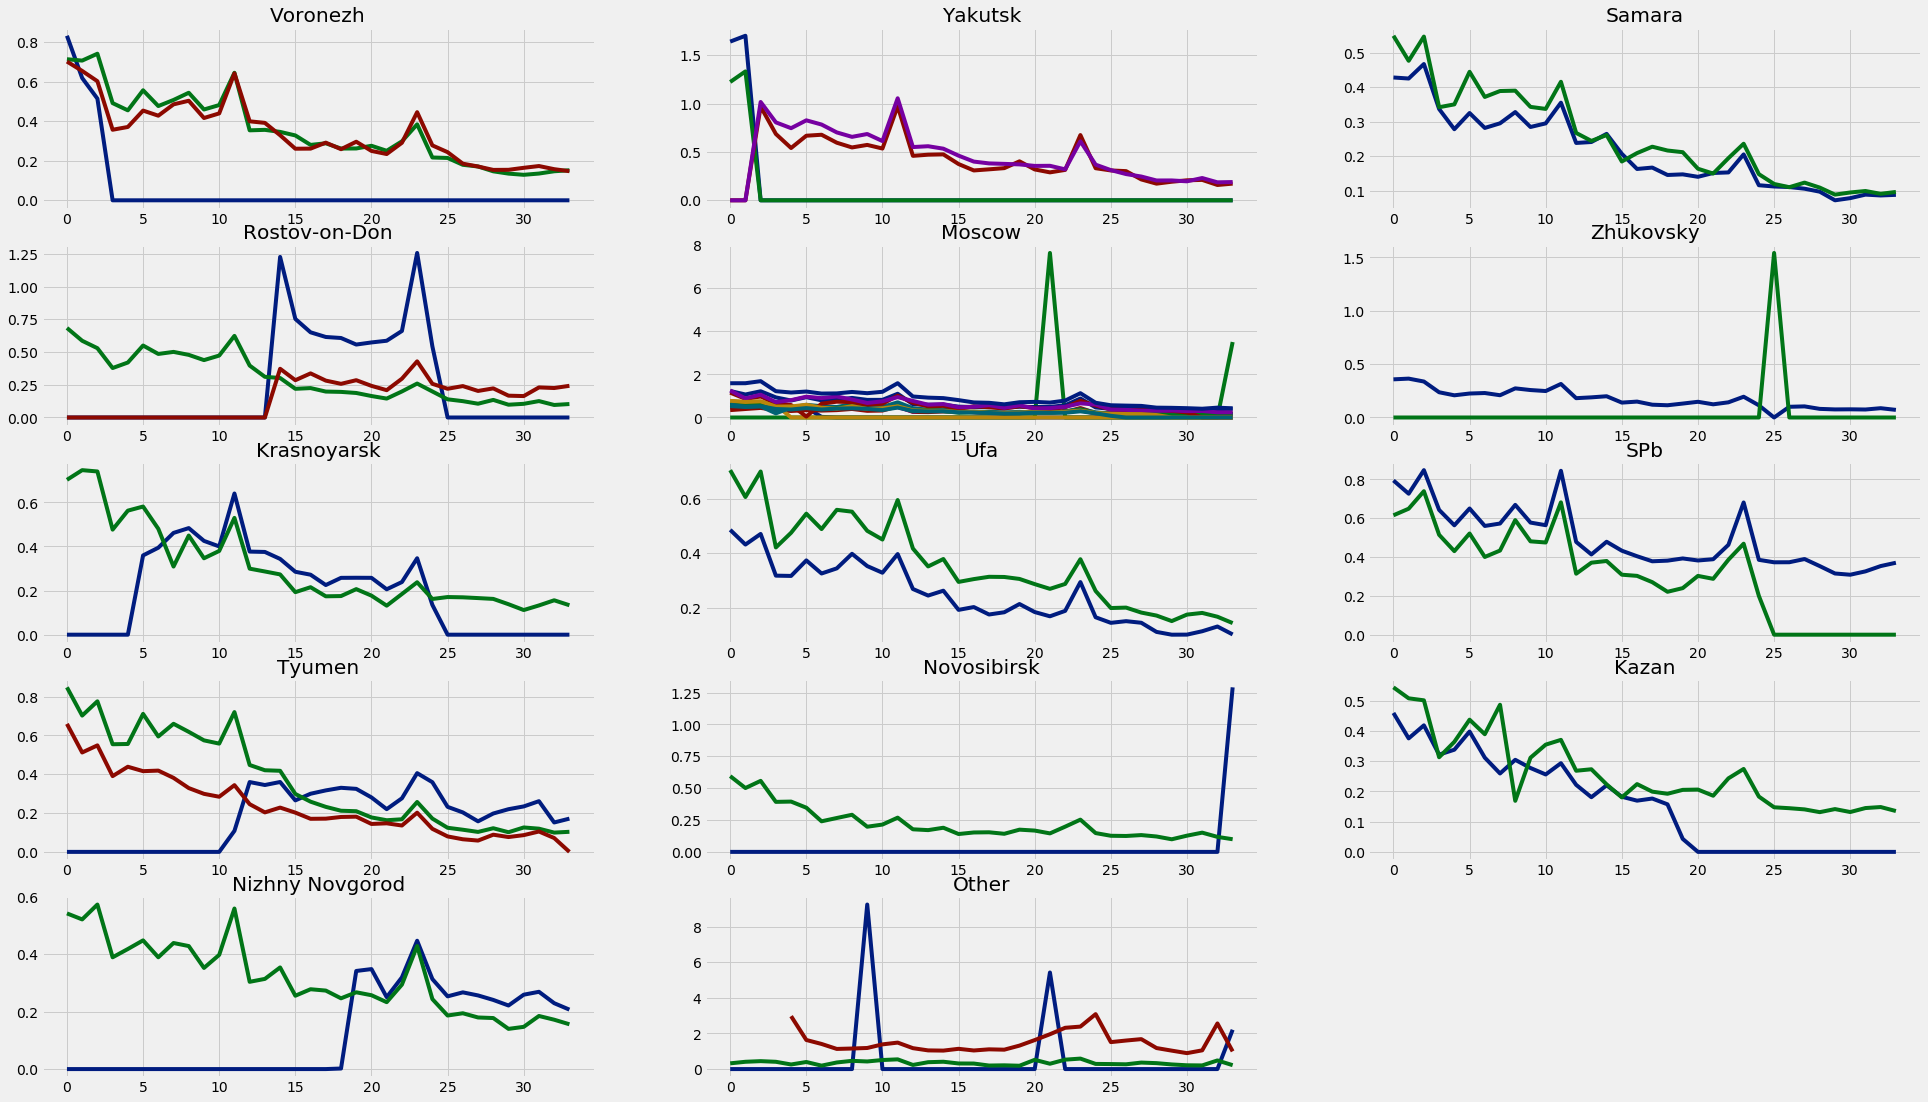

In [171]:
#5x3
plt.figure(figsize=(30,18))

i=1
for c in set(shop_mean_by_city["city_name"]):
    shops_id_c = set(shop_mean_by_city.loc[shop_mean_by_city["city_name"]==c,"shop_id"])
    if len(set(shops_id_c))>1:
        for s_id in shops_id_c:
            shops_id_c_tmp = shop_mean_by_city.loc[shop_mean_by_city["shop_id"]==s_id,]
            plt.subplot(5,3,i)
            plt.plot(shops_id_c_tmp["date_block_num"],shops_id_c_tmp["item_cnt_month"])
        i+=1
        plt.title(c)

plt.show()

The distribution seems alike within a city -> use city name to compute mean

In [172]:
cityxmonth_mean = (df_fe.groupby(["city_name","date_block_num"])
                                        .agg({"item_cnt_month": "mean", 
                                              "mean_item_price": "mean", 
                                              "std_item_price": "mean"})
                                        .reset_index())
cityxmonth_mean.columns = ["city_name","date_block_num","mean_city_cnt_month",
                              "mean_city_item_price","std_city_item_price"]
cityxmonth_mean.head(2)

,city_name,date_block_num,mean_city_cnt_month,mean_city_item_price,std_city_item_price
0,Adygea,0,0.644096,895.874067,4.920526
1,Adygea,1,0.252583,851.558770,6.026745


In [173]:
df_fe = pd.merge(df_fe, cityxmonth_mean, how="left", on=["city_name","date_block_num"])
df_fe.head(2)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,...,std_item_price_lag2,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag12,mean_category_cnt_month,mean_category_item_price,std_category_item_price,mean_city_cnt_month,mean_city_item_price,std_city_item_price
0,0,16385,0,20.01.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,NaN,NaN,NaN,NaN,1.578653,961.358806,12.768717,0.581237,513.799861,2.299256
1,0,16385,1,25.02.2013,200.0,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,NaN,2.0,NaN,NaN,1.495422,888.887935,20.991397,0.600810,501.004109,2.523964


In [174]:
df_fe.columns

Index(['shop_id', 'item_id', 'date_block_num', 'random_date',
       'mean_item_price', 'std_item_price', 'item_cnt_month', 'days_with_sell',
       'item_name', 'item_category_id', 'main_category_name',
       'sub_category_name', 'city_name', 'item_cnt_next_month', 'month',
       'year', 'nb_days', 'mean_item_price_lag1', 'mean_item_price_lag2',
       'std_item_price_lag1', 'std_item_price_lag2', 'item_cnt_month_lag1',
       'item_cnt_month_lag2', 'item_cnt_month_lag12',
       'mean_category_cnt_month', 'mean_category_item_price',
       'std_category_item_price', 'mean_city_cnt_month',
       'mean_city_item_price', 'std_city_item_price'],
      dtype='object')

##### Lag of category + city based features

In [175]:
for feature in ['mean_category_cnt_month', 'mean_category_item_price',
               'std_category_item_price', 'mean_city_cnt_month',
               'mean_city_item_price', 'std_city_item_price']:
    df_fe[feature+"_lag1"] = (df_fe.sort_values("date_block_num")
                                        .groupby(["shop_id","item_id"])[feature].shift(1))

In [176]:
df_fe.columns

Index(['shop_id', 'item_id', 'date_block_num', 'random_date',
       'mean_item_price', 'std_item_price', 'item_cnt_month', 'days_with_sell',
       'item_name', 'item_category_id', 'main_category_name',
       'sub_category_name', 'city_name', 'item_cnt_next_month', 'month',
       'year', 'nb_days', 'mean_item_price_lag1', 'mean_item_price_lag2',
       'std_item_price_lag1', 'std_item_price_lag2', 'item_cnt_month_lag1',
       'item_cnt_month_lag2', 'item_cnt_month_lag12',
       'mean_category_cnt_month', 'mean_category_item_price',
       'std_category_item_price', 'mean_city_cnt_month',
       'mean_city_item_price', 'std_city_item_price',
       'mean_category_cnt_month_lag1', 'mean_category_item_price_lag1',
       'std_category_item_price_lag1', 'mean_city_cnt_month_lag1',
       'mean_city_item_price_lag1', 'std_city_item_price_lag1'],
      dtype='object')

##### is_lowest_price within the city?

In [178]:
df_fe_lowest_price = (df_fe.groupby(["city_name","item_id","date_block_num"])
                            .agg({"mean_item_price":"min"})
                            .reset_index())
df_fe_lowest_price = df_fe_lowest_price.rename({"mean_item_price":"lowest_price"}, axis=1)
df_fe_lowest_price.sample(n=3)

,city_name,item_id,date_block_num,lowest_price
971989,Kazan,18977,30,478.854276
6855796,Zhukovsky,21605,33,99.000000
5424908,Ufa,20187,21,350.000000


In [179]:
df_fe = pd.merge(df_fe, df_fe_lowest_price, how="left", on=["city_name","item_id","date_block_num"])
df_fe["is_lowest_price"] = (df_fe["mean_item_price"] == df_fe["lowest_price"])
df_fe = df_fe.drop("lowest_price", axis=1)
df_fe.head(3)

,shop_id,item_id,date_block_num,random_date,mean_item_price,std_item_price,item_cnt_month,days_with_sell,item_name,item_category_id,...,mean_city_cnt_month,mean_city_item_price,std_city_item_price,mean_category_cnt_month_lag1,mean_category_item_price_lag1,std_category_item_price_lag1,mean_city_cnt_month_lag1,mean_city_item_price_lag1,std_city_item_price_lag1,is_lowest_price
0,0,16385,0,20.01.2013,200.0000,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,0.581237,513.799861,2.299256,NaN,NaN,NaN,NaN,NaN,NaN,True
1,0,16385,1,25.02.2013,200.0000,0.0,2.0,2.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,0.600810,501.004109,2.523964,1.578653,961.358806,12.768717,0.581237,513.799861,2.299256,True
2,0,16385,2,01.03.2013,348.9375,0.0,0.0,0.0,"Нэнси Дрю. Сгоревшее алиби [PC, Jewel]",30,...,0.628642,542.716820,3.613144,1.495422,888.887935,20.991397,0.600810,501.004109,2.523964,True


### Exports

In [180]:
df_fe.to_pickle("cleaned_sets/df_features.pkl")

# Feature Selection